# Build convrnn

So we've downloaded the dataset and analyzed and visualized it. We're ready now for the next step: building the convrnn.

We first test it with a synthetic dataset: a ball that bounces.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from convlstm_pytorch import ConvLSTM
from synthetic_datasets import Ball
import utils

In [2]:
# Give init parameters here
b = Ball()
# Calling an instance of Ball generates a batch of images
utils.plotting.plot_synthetic(b(sequence_length=10))

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, torch.nn.Conv2d):
        m.weight.data.normal_(0.0, 0.02)

use_cuda = True

input_size = (100,100)
input_dim = 1
num_layers = 4
# Last hidden output is overall output so should be 1
hidden_dim = [8,16,32,1]
kernel_size = (5,5)

# Meta params
learning_rate = .01
n_batches = 200
# TODO: Implement getting multiple batches of Ball() sequences
batch_size = 20
sequence_length = 8

encoder = ConvLSTM(input_size, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=True, bias=True, return_all_layers=True, use_cuda=use_cuda)
decoder = ConvLSTM(input_size, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=True, bias=True, return_all_layers=True, use_cuda=use_cuda)

encoder.apply(weights_init)
decoder.apply(weights_init)

if use_cuda:
    encoder.cuda()
    decoder.cuda()

optim = torch.optim.Adam(list(encoder.parameters())+list(decoder.parameters()), lr=learning_rate)

losses = []

for i_b in range(n_batches):
    
    batch = np.ndarray((batch_size, sequence_length, 1, input_size[0], input_size[1]),
                      dtype=np.float32)
    
    for i_s in range(batch_size):
        # Shape now (t,w,h). Convert to floats
        sample = b(sequence_length=sequence_length).astype(np.float32)
        # Shape (t, c, h, w) where t is sequence length
        batch[i_s, :] = sample[:, np.newaxis, :, :]
        # Shape (b, t, c, h, w)

    inputs, targets = batch[:,:sequence_length//2], batch[:,sequence_length//2:]

    inputs_var = torch.autograd.variable.Variable(torch.from_numpy(inputs), requires_grad=True)
    targets_var = torch.autograd.variable.Variable(torch.from_numpy(targets))
    
    if use_cuda:
        inputs_var = inputs_var.cuda()
        targets_var = targets_var.cuda()

    # Do pass over inputs, we don't care about outputs other than the last one
    layer_output_list, last_state_list = encoder.forward(inputs_var)
    # Highest layer last timestep (to feed into first step of decoder next to state)
    # Slice to retain dims
    cur_inp = layer_output_list[-1][:,-1:]

    # Now we're
    preds = []
    for i_p in range(targets.shape[1]):
        layer_output_list, last_state_list = decoder.forward(cur_inp, hidden_state=last_state_list)
        # Eat your own dogfood
        cur_inp = layer_output_list[-1][:,-1:]
        preds.append(cur_inp)

    # CALCULATE ERROR
    loss_func = torch.nn.MSELoss()
    loss = 0
    for i_t, p in enumerate(preds):
        loss += loss_func(p, targets_var[:,i_t])
    
    optim.zero_grad()

    loss.backward()
    
    optim.step()

    print("Batch {:4d} loss: {:.5f} min {: 2.2f} max {: 2.2f}".format(i_b, loss.data[0],
                            float(layer_output_list[0].min().data.cpu().numpy()), float(layer_output_list[0].max().data.cpu().numpy())))
    losses.append(loss.data[0])


Batch    0 loss: 0.35613 min -0.03 max  0.03
Batch    1 loss: 0.22220 min -0.03 max  0.03
Batch    2 loss: 0.29043 min -0.03 max  0.03
Batch    3 loss: 0.21650 min -0.03 max  0.03
Batch    4 loss: 0.26413 min -0.03 max  0.03
Batch    5 loss: 0.28163 min -0.04 max  0.04
Batch    6 loss: 0.23294 min -0.04 max  0.04
Batch    7 loss: 0.27034 min -0.04 max  0.04
Batch    8 loss: 0.23833 min -0.05 max  0.04
Batch    9 loss: 0.22104 min -0.09 max  0.04
Batch   10 loss: 0.19501 min -0.15 max  0.07
Batch   11 loss: 0.22643 min -0.23 max  0.10
Batch   12 loss: 0.22345 min -0.25 max  0.13
Batch   13 loss: 0.18864 min -0.24 max  0.13
Batch   14 loss: 0.20686 min -0.23 max  0.13
Batch   15 loss: 0.23929 min -0.24 max  0.14
Batch   16 loss: 0.23863 min -0.27 max  0.18
Batch   17 loss: 0.27503 min -0.34 max  0.25
Batch   18 loss: 0.21061 min -0.44 max  0.35
Batch   19 loss: 0.20820 min -0.55 max  0.48
Batch   20 loss: 0.22526 min -0.63 max  0.59
Batch   21 loss: 0.20886 min -0.70 max  0.65
Batch   22

Batch  183 loss: 0.09436 min -0.65 max  0.50
Batch  184 loss: 0.06776 min -0.63 max  0.48
Batch  185 loss: 0.07126 min -0.65 max  0.50
Batch  186 loss: 0.08676 min -0.65 max  0.49
Batch  187 loss: 0.07031 min -0.62 max  0.46
Batch  188 loss: 0.08985 min -0.65 max  0.50
Batch  189 loss: 0.07386 min -0.60 max  0.46
Batch  190 loss: 0.07125 min -0.64 max  0.48
Batch  191 loss: 0.09136 min -0.62 max  0.47
Batch  192 loss: 0.09049 min -0.62 max  0.46
Batch  193 loss: 0.07287 min -0.58 max  0.42
Batch  194 loss: 0.07650 min -0.61 max  0.46
Batch  195 loss: 0.08534 min -0.59 max  0.44
Batch  196 loss: 0.10151 min -0.62 max  0.46
Batch  197 loss: 0.07970 min -0.62 max  0.46
Batch  198 loss: 0.08741 min -0.60 max  0.44
Batch  199 loss: 0.07389 min -0.59 max  0.43


Lowest: 0.05822


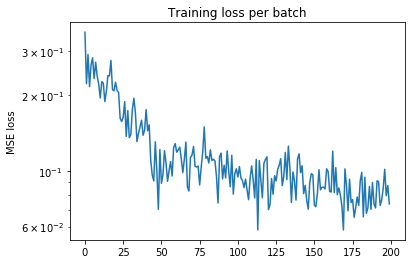

In [18]:
plt.clf()
fig, ax = plt.subplots()
ax.set_title("Training loss per batch")
ax.set_ylabel('MSE loss')
ax.plot(losses)
ax.set_yscale('log')
print("Lowest: {:.5f}".format(min(losses)))
plt.show()

In [19]:
# PLOT OUTPUT
# (b, seq_len, c, w, h)
pred = preds[]
# Extract FloatTensor from Variable, convert to numpy.ndarray
if use_cuda:
    pred = pred.data.cpu().numpy()
else:
    pred = pred.data.numpy()

# Take first of batch, channel axes
# targets is already np.array
t = targets[0,:,0]

imgs = np.empty((sequence_length, *input_size), dtype=imgs.dtype)

interleaved[:]  = t
interleaved[1::2] = imgs[len(t):]

utils.plotting.plot_synthetic(imgs, interval=300)

In [25]:
preds[0].size()

torch.Size([20, 1, 1, 100, 100])